# COVIDcast Data Smoothing
In this document, we compare different methods of smoothing [COVIDcast signals](https://github.com/cmu-delphi/delphi-epidata/blob/e7cd1012d2046980571a3ded6db6803f64e4506b/docs/api/covidcast_signals.md). See the README.md file for the problem statement and the mathematical background.

The dependencies are listed below. To rerun this notebook, `covidcast` and `delphi_utils` from [this branch](https://github.com/cmu-delphi/covidcast-indicators/tree/dev-smoothing) should be installed in your python environment.

In [1]:
import os
from datetime import date
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import covidcast
from delphi_utils import Smoother

## An Example: Google Health Trends - California, Raw
To begin, let's load a raw example signal, say the [Google Health Trends signal](https://github.com/cmu-delphi/delphi-epidata/blob/main/docs/api/covidcast-signals/ght.md) `ght` which records Google search activity.

In [2]:
filename = "ght_raw.csv"
if filename not in os.listdir():
    data_raw = covidcast.signal("ght", "raw_search", 
                                start_day=None, end_day=None,
                                geo_type="state", geo_values="ca")
    data_raw.to_csv(filename)
else:
    data_raw = pd.read_csv(filename)

Let's look at how the smoothers work on this signal.

We have three smoothers: `left_gauss_linear` and `savgol` with polynomial degrees 0 and 2. Simplifying a little, `left_gauss_linear` smooths by fitting a line through the most recent 3 weeks of data, exponentially favoring the most recent data, while `savgol` uses the same data weights, but fits polynomials of degree 0 or 2 through the data (higher degree polynomials are possible, but are extremely noise sensitive). 

We show the performance of each smoother on 2 different time windows: 14 and 7 days.

It is clear that polynomial degree increases the amount of noise passed through at the cost of lag. Decreasing the smoothing window reduces the impact of the lag.

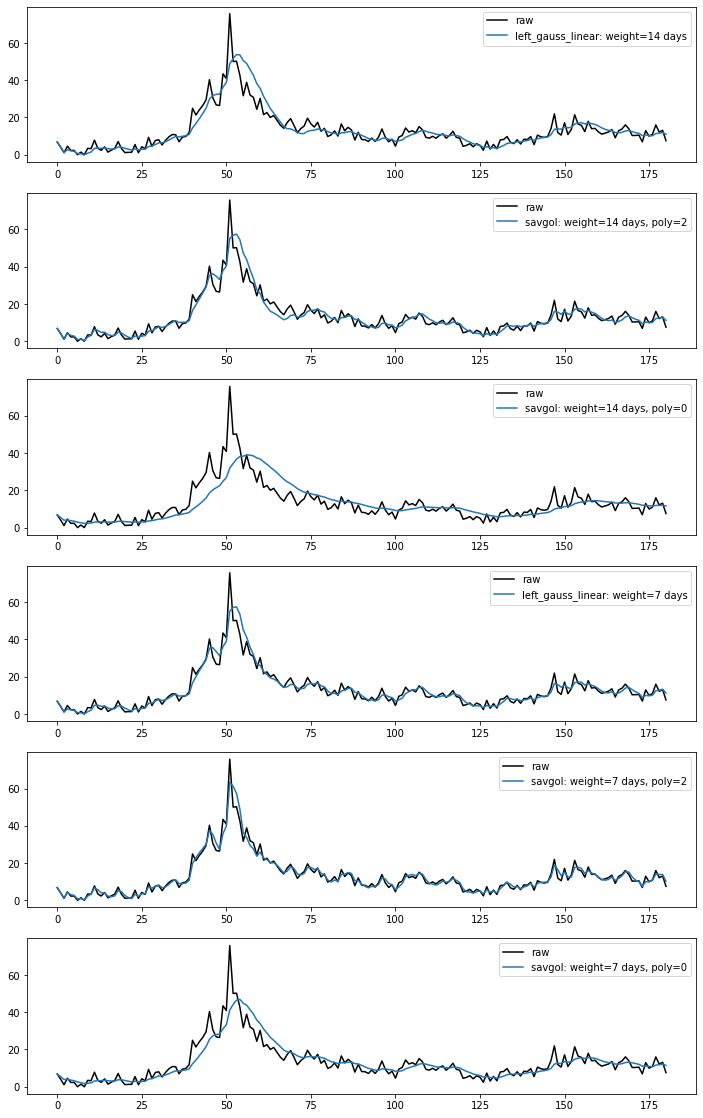

In [3]:
plt.figure(figsize=(12, 20))
plt.title("GHT Raw California")
plt.subplot(6, 1, 1)
plt.plot(np.array(data_raw.value), label="raw", color="black")
smoother = Smoother(method_name='left_gauss_linear', gaussian_bandwidth=144)
plt.plot(smoother.smooth(np.array(data_raw.value)), label="left_gauss_linear: weight=14 days")
plt.legend()

plt.subplot(6, 1, 2)
plt.plot(np.array(data_raw.value), label="raw", color="black")
smoother = Smoother(gaussian_bandwidth=144)
plt.plot(smoother.smooth(np.array(data_raw.value)), label="savgol: weight=14 days, poly=2")
plt.legend()

plt.subplot(6, 1, 3)
plt.plot(np.array(data_raw.value), label="raw", color="black")
smoother = Smoother(poly_fit_degree=0, gaussian_bandwidth=144)
plt.plot(smoother.smooth(np.array(data_raw.value)), label="savgol: weight=14 days, poly=0")
plt.legend()

plt.subplot(6, 1, 4)
plt.plot(np.array(data_raw.value), label="raw", color="black")
smoother = Smoother(method_name='left_gauss_linear', gaussian_bandwidth=36)
plt.plot(smoother.smooth(np.array(data_raw.value)), label="left_gauss_linear: weight=7 days")
plt.legend()

plt.subplot(6, 1, 5)
plt.plot(np.array(data_raw.value), label="raw", color="black")
smoother = Smoother(gaussian_bandwidth=36)
plt.plot(smoother.smooth(np.array(data_raw.value)), label="savgol: weight=7 days, poly=2")
plt.legend()

plt.subplot(6, 1, 6)
plt.plot(np.array(data_raw.value), label="raw", color="black")
smoother = Smoother(poly_fit_degree=0, gaussian_bandwidth=36)
plt.plot(smoother.smooth(np.array(data_raw.value)), label="savgol: weight=7 days, poly=0")
plt.legend()

Note that `savgol` with polynomial degree 1 is almost identical to `left_gauss_linear`. The `savgol` implementation is faster, so in the future should replace `left_gauss_linear`.

In [4]:
lgl_smoother = Smoother(method_name='left_gauss_linear')
sg_smoother = Smoother(poly_fit_degree=1)
np.allclose(sg_smoother.smooth(np.array(data_raw.value)), lgl_smoother.smooth(np.array(data_raw.value)), atol=2)

True

## An example of sparse data: GHT - HRR level
There tends to be less data at the county and hrr levels, which leads to more zeros. We want our smoothers to work well in these situations.

Let's take a look at `ght` again, in the hospital regions around Pittsburgh and Sacramento.

In [5]:
filename = "ght_raw_hrr_pittsburgh.csv"
if filename not in os.listdir():
    data_raw = covidcast.signal("ght", "raw_search", 
                                start_day=None, end_day=None,
                                geo_type="hrr", geo_values="357")
    data_raw.to_csv(filename)
else:
    data_raw = pd.read_csv(filename)

The plot layout is the same as before. The robustness of the 0 degree `savgol` is more apparent here.

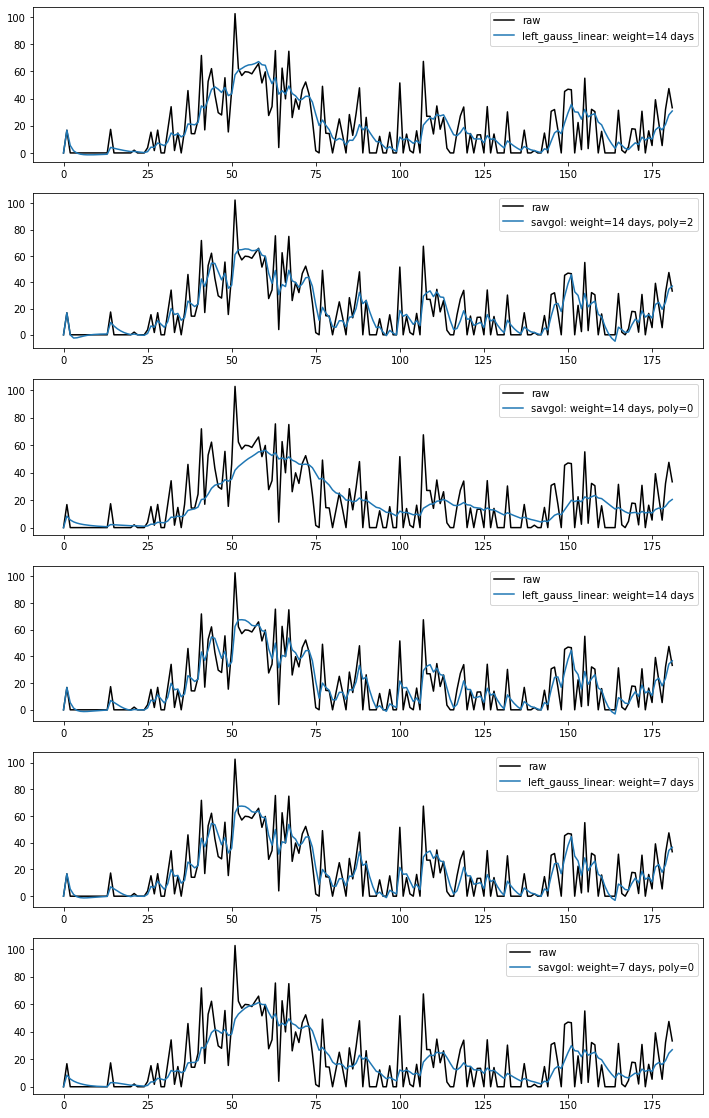

In [6]:
plt.figure(figsize=(12, 20))
plt.title("GHT HRR Pittsburgh")
plt.subplot(6, 1, 1)
plt.plot(np.array(data_raw.value), label="raw", color='black')
smoother = Smoother(method_name='left_gauss_linear', gaussian_bandwidth=144)
plt.plot(smoother.smooth(np.array(data_raw.value)), label="left_gauss_linear: weight=14 days")
plt.legend()

plt.subplot(6, 1, 2)
smoother = Smoother(gaussian_bandwidth=144)
plt.plot(np.array(data_raw.value), label="raw", color='black')
plt.plot(smoother.smooth(np.array(data_raw.value)), label="savgol: weight=14 days, poly=2")
plt.legend()

plt.subplot(6, 1, 3)
plt.plot(np.array(data_raw.value), label="raw", color='black')
smoother = Smoother(poly_fit_degree=0, gaussian_bandwidth=144)
plt.plot(smoother.smooth(np.array(data_raw.value)), label="savgol: weight=14 days, poly=0")
plt.legend()

plt.subplot(6, 1, 4)
plt.plot(np.array(data_raw.value), label="raw", color='black')
smoother = Smoother(method_name='left_gauss_linear', gaussian_bandwidth=36)
plt.plot(smoother.smooth(np.array(data_raw.value)), label="left_gauss_linear: weight=14 days")
plt.legend()

plt.subplot(6, 1, 5)
plt.plot(np.array(data_raw.value), label="raw", color='black')
smoother = Smoother(method_name='left_gauss_linear', gaussian_bandwidth=36)
plt.plot(smoother.smooth(np.array(data_raw.value)), label="left_gauss_linear: weight=7 days")
plt.legend()

plt.subplot(6, 1, 6)
plt.plot(np.array(data_raw.value), label="raw", color='black')
smoother = Smoother(poly_fit_degree=0, gaussian_bandwidth=36)
plt.plot(smoother.smooth(np.array(data_raw.value)), label="savgol: weight=7 days, poly=0")
plt.legend()

Looking at another hospital region, Sacramento, the same pattern holds.

In [7]:
filename = "ght_raw_hrr_sacramento.csv"
if filename not in os.listdir():
    data_raw = covidcast.signal("ght", "raw_search", 
                                start_day=None, end_day=None,
                                geo_type="hrr", geo_values="77")
    data_raw.to_csv(filename)
else:
    data_raw = pd.read_csv(filename)

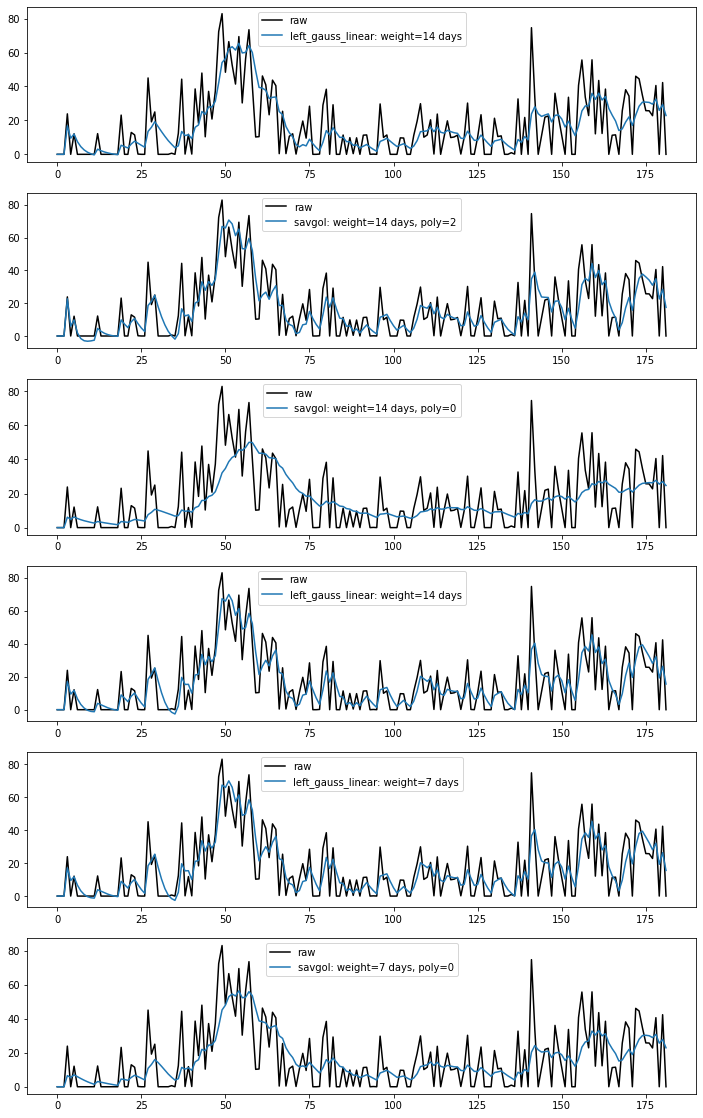

In [8]:
plt.figure(figsize=(12, 20))
plt.title("GHT HRR Sacramento")
plt.subplot(6, 1, 1)
plt.plot(np.array(data_raw.value), label="raw", color='black')
smoother = Smoother(method_name='left_gauss_linear', gaussian_bandwidth=144)
plt.plot(smoother.smooth(np.array(data_raw.value)), label="left_gauss_linear: weight=14 days")
plt.legend()

plt.subplot(6, 1, 2)
smoother = Smoother(gaussian_bandwidth=144)
plt.plot(np.array(data_raw.value), label="raw", color='black')
plt.plot(smoother.smooth(np.array(data_raw.value)), label="savgol: weight=14 days, poly=2")
plt.legend()

plt.subplot(6, 1, 3)
plt.plot(np.array(data_raw.value), label="raw", color='black')
smoother = Smoother(poly_fit_degree=0, gaussian_bandwidth=144)
plt.plot(smoother.smooth(np.array(data_raw.value)), label="savgol: weight=14 days, poly=0")
plt.legend()

plt.subplot(6, 1, 4)
plt.plot(np.array(data_raw.value), label="raw", color='black')
smoother = Smoother(method_name='left_gauss_linear', gaussian_bandwidth=36)
plt.plot(smoother.smooth(np.array(data_raw.value)), label="left_gauss_linear: weight=14 days")
plt.legend()

plt.subplot(6, 1, 5)
plt.plot(np.array(data_raw.value), label="raw", color='black')
smoother = Smoother(method_name='left_gauss_linear', gaussian_bandwidth=36)
plt.plot(smoother.smooth(np.array(data_raw.value)), label="left_gauss_linear: weight=7 days")
plt.legend()

plt.subplot(6, 1, 6)
plt.plot(np.array(data_raw.value), label="raw", color='black')
smoother = Smoother(poly_fit_degree=0, gaussian_bandwidth=36)
plt.plot(smoother.smooth(np.array(data_raw.value)), label="savgol: weight=7 days, poly=0")
plt.legend()

## JHU-CSSE - County level
The same analysis on a different indicator, `jhu-csse` at the county level, yields the same pattern `savgol`.

In [9]:
filename = "jhu_confirmed_incidence_county_yolo.csv"
if filename not in os.listdir():
    data_raw = covidcast.signal(data_source="jhu-csse", 
                                signal="confirmed_incidence_num", 
                                start_day=None, 
                                end_day=None, 
                                geo_type="county", 
                                geo_values="06113")
    data_raw.to_csv(filename)
else:
    data_raw = pd.read_csv(filename)

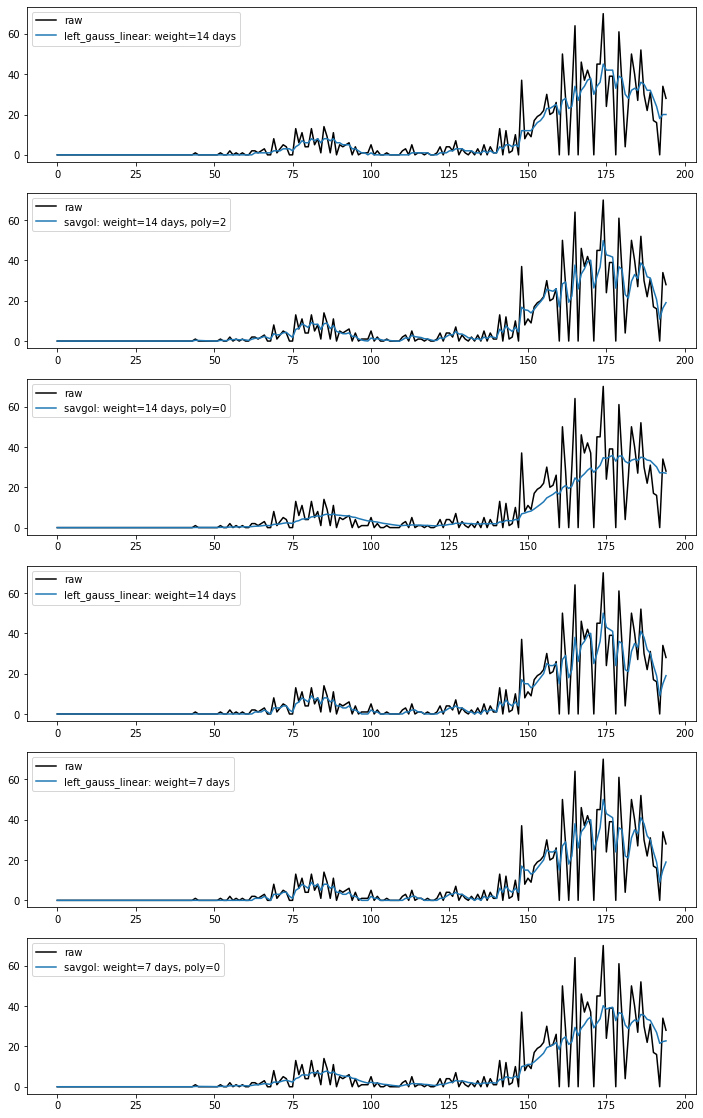

In [10]:
plt.figure(figsize=(12, 20))
plt.title("JHU County Yolo")
plt.subplot(6, 1, 1)
plt.plot(np.array(data_raw.value), label="raw", color='black')
smoother = Smoother(method_name='left_gauss_linear', gaussian_bandwidth=144)
plt.plot(smoother.smooth(np.array(data_raw.value)), label="left_gauss_linear: weight=14 days")
plt.legend()

plt.subplot(6, 1, 2)
smoother = Smoother(gaussian_bandwidth=144)
plt.plot(np.array(data_raw.value), label="raw", color='black')
plt.plot(smoother.smooth(np.array(data_raw.value)), label="savgol: weight=14 days, poly=2")
plt.legend()

plt.subplot(6, 1, 3)
plt.plot(np.array(data_raw.value), label="raw", color='black')
smoother = Smoother(poly_fit_degree=0, gaussian_bandwidth=144)
plt.plot(smoother.smooth(np.array(data_raw.value)), label="savgol: weight=14 days, poly=0")
plt.legend()

plt.subplot(6, 1, 4)
plt.plot(np.array(data_raw.value), label="raw", color='black')
smoother = Smoother(method_name='left_gauss_linear', gaussian_bandwidth=36)
plt.plot(smoother.smooth(np.array(data_raw.value)), label="left_gauss_linear: weight=14 days")
plt.legend()

plt.subplot(6, 1, 5)
plt.plot(np.array(data_raw.value), label="raw", color='black')
smoother = Smoother(method_name='left_gauss_linear', gaussian_bandwidth=36)
plt.plot(smoother.smooth(np.array(data_raw.value)), label="left_gauss_linear: weight=7 days")
plt.legend()

plt.subplot(6, 1, 6)
plt.plot(np.array(data_raw.value), label="raw", color='black')
smoother = Smoother(poly_fit_degree=0, gaussian_bandwidth=36)
plt.plot(smoother.smooth(np.array(data_raw.value)), label="savgol: weight=7 days, poly=0")
plt.legend()

Allegheny county supports the result.

In [11]:
filename = "jhu_confirmed_incidence_county_allegheny.csv"
if filename not in os.listdir():
    data_raw = covidcast.signal(data_source="jhu-csse", 
                                signal="confirmed_incidence_num", 
                                start_day=None, 
                                end_day=None, 
                                geo_type="county", 
                                geo_values="42003")
    data_raw.to_csv(filename)
else:
    data_raw = pd.read_csv(filename)

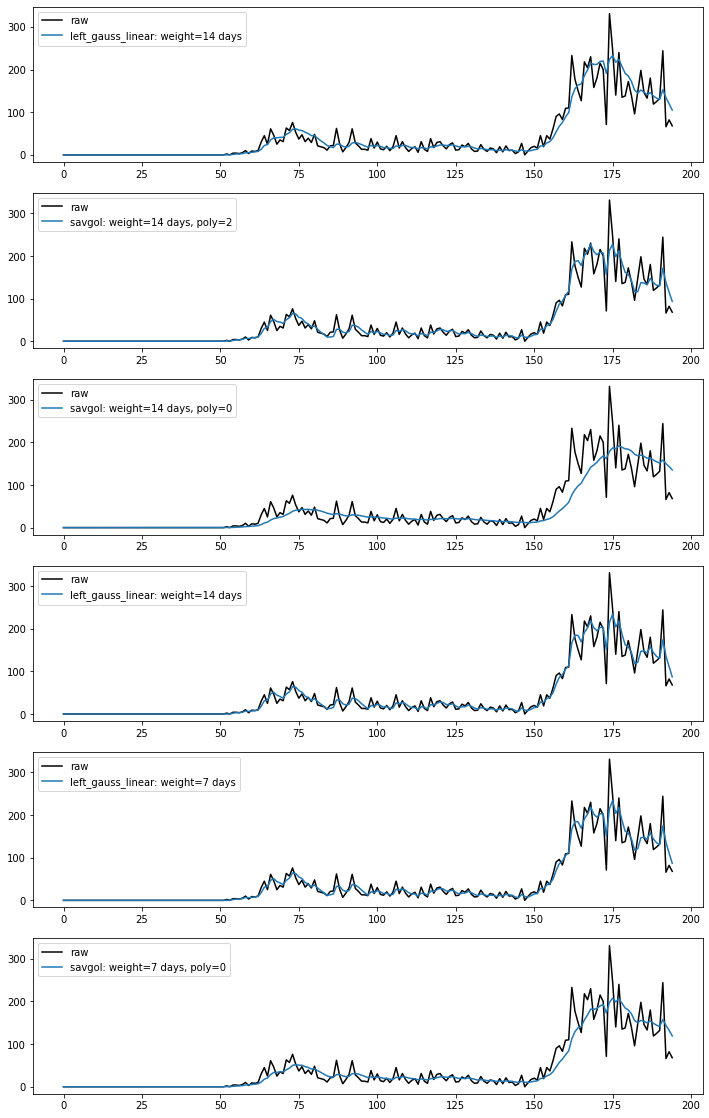

In [12]:
plt.figure(figsize=(12, 20))
plt.title("JHU County Allegheny")
plt.subplot(6, 1, 1)
plt.plot(np.array(data_raw.value), label="raw", color='black')
smoother = Smoother(method_name='left_gauss_linear', gaussian_bandwidth=144)
plt.plot(smoother.smooth(np.array(data_raw.value)), label="left_gauss_linear: weight=14 days")
plt.legend()

plt.subplot(6, 1, 2)
smoother = Smoother(gaussian_bandwidth=144)
plt.plot(np.array(data_raw.value), label="raw", color='black')
plt.plot(smoother.smooth(np.array(data_raw.value)), label="savgol: weight=14 days, poly=2")
plt.legend()

plt.subplot(6, 1, 3)
plt.plot(np.array(data_raw.value), label="raw", color='black')
smoother = Smoother(poly_fit_degree=0, gaussian_bandwidth=144)
plt.plot(smoother.smooth(np.array(data_raw.value)), label="savgol: weight=14 days, poly=0")
plt.legend()

plt.subplot(6, 1, 4)
plt.plot(np.array(data_raw.value), label="raw", color='black')
smoother = Smoother(method_name='left_gauss_linear', gaussian_bandwidth=36)
plt.plot(smoother.smooth(np.array(data_raw.value)), label="left_gauss_linear: weight=14 days")
plt.legend()

plt.subplot(6, 1, 5)
plt.plot(np.array(data_raw.value), label="raw", color='black')
smoother = Smoother(method_name='left_gauss_linear', gaussian_bandwidth=36)
plt.plot(smoother.smooth(np.array(data_raw.value)), label="left_gauss_linear: weight=7 days")
plt.legend()

plt.subplot(6, 1, 6)
plt.plot(np.array(data_raw.value), label="raw", color='black')
smoother = Smoother(poly_fit_degree=0, gaussian_bandwidth=36)
plt.plot(smoother.smooth(np.array(data_raw.value)), label="savgol: weight=7 days, poly=0")
plt.legend()

## Conclusion
As we have seen, `savgol` with polynomial degree 0 provides reasonable smoothing in the sparse regime. This comes at the cost of some lag, so the weighing window must be reduced. This lag may be too large for the raw data, even with a 7 day window to reduce it, so it may be best to continue to use the 1 degree polynomial fit there, depending on our needs.

## Other Signals
Many of the other signals had obstacles to a clear comparison.

- The `doctor-visits` and `hospital-admissions` [signal](https://github.com/cmu-delphi/delphi-epidata/blob/main/docs/api/covidcast-signals/doctor-visits.md) are already smoothed by the provider. The raw data does not appear to be available.
- The `fb-survey` and `google-survey` signal require access to the survey data. 